# Fixed Coupon Bond

The goal of the project is to compute the market value of a portfolio if fixed coupon bonds taking into account the issuer credit risk. The input parameters to derive this curve are:

* The par rate of a set of Overnight Index Swaps (i.e. their market quotation)
* A set of survival probabilities and the recovery rate of the issuer
* The static data of the pool of bonds (nominal, start date, end date, coupons, payment frequency)

### Notes and hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for evaluation of risky flows.

All maturities are expressed in months and rates are expressed as fractions of one (i.e. 0.01 means 1%).

Remember to reuse the code we developed during the lessons in `finmarkets.py` as much as possible, instead of trying to rewrite everything from scratch!

In [4]:
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta

today = date(2019, 10, 31)

ois_quotes = pd.read_csv("ois_quotes.csv").to_dict('records')

df = pd.read_csv("survival_probabilities_proj4.csv")
df['date'] = pd.to_datetime(df['date']).dt.date
survival_probabilities = df.to_dict('records')

df = pd.read_csv("bonds_to_price_proj4.csv")
df['start_date'] = pd.to_datetime(df['start_date']).dt.date
df['end_date'] = pd.to_datetime(df['end_date']).dt.date
bonds_to_price = df.to_dict('records')

First of all we need to determine the discount curve from the market quotes of a set of OIS using the bootstrap technique. Also, before defining the discount curve I have checked the minimization results).

In [5]:
from finmarkets import DiscountCurve, OvernightIndexSwap, generate_swap_dates

pillar_dates = [today]

swaps = []

for quote in ois_quotes:
    swap = OvernightIndexSwap(
        1e6, 
        generate_swap_dates(today, quote['maturity']),
        quote['rate'])
    
    swaps.append(swap)
    pillar_dates.append(swap.payment_dates[-1])

pillar_dates = sorted(pillar_dates)

In [6]:
def objective_function(x):
    curve = DiscountCurve(today, pillar_dates, x)
    sum_sq = 0.0
    for swap in swaps:
        sum_sq += swap.npv(curve) ** 2
        
    return sum_sq 

In [7]:
from scipy.optimize import minimize

x0 = [1.0 for i in range(len(pillar_dates))]
bounds = [(0.01, 100.0) for i in range(len(pillar_dates))]
bounds[0] = (1.0, 1.0)

result = minimize(objective_function, x0, bounds=bounds)

[1.         0.99991167 0.99980687 0.99970619 0.99961015 0.99950111
 0.999392   0.99928207 0.99916713 0.99903027 0.998895   0.99874906
 0.99860278 0.99807334 0.99748678 0.99674625 0.99583439 0.98958294
 0.97817155 0.9622335  0.94245275 0.91997975 0.89555481 0.86968378
 0.84283835 0.81600063 0.78928833 0.7134728  0.61195787 0.53249163
 0.46686384]
1398807951100.5293
0.0006561289556596521


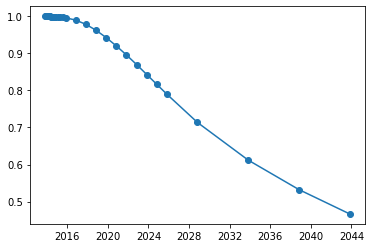

In [9]:
print (result.x)
print (objective_function(x0))
print (objective_function(result.x))

from matplotlib import pyplot as plt
plt.plot(pillar_dates, result.x, marker='o')
plt.show()

In [10]:
discount_curve = DiscountCurve(today, pillar_dates, result.x)

Then ww need to determine the credit curve from the non-default probabilities given in input.

In [11]:
from finmarkets import CreditCurve

date=[today]

ndp=[1.0]

for quote in survival_probabilities:
    date.append(quote['date'])
    ndp.append(quote['ndp'])
    
cc = CreditCurve(date, ndp)

In the end a new class to price the bonds has been developed. The same class is used later to compute the portfolio value.

In [12]:
from math import exp

class Price:
    
    def __init__(self, notional, d1, d2, today, 
                 coupon, frequency, recovery):

        self.notional = notional
        self.d1 = d1
        self.d2 = d2
        self.today = today
        self.coupon = coupon
        self.frequency = frequency
        self.recovery = recovery
           
    def cpd(self):
        coupon_dates = []
        now = self.d1
        
        while now + relativedelta(months=self.frequency) < self.d2:
            now += relativedelta(months=self.frequency)
            coupon_dates.append(now)
            
        coupon_dates.append(self.d2)
        coupon_dates = [i for i in coupon_dates if i >= self.today]
        
        return coupon_dates
    
    def haz(self, end):
        hazard=0.0
        t=0
        
        while t <= end: 
            hazard += cc.ndp(today+relativedelta(days=t)) - \
                      cc.ndp(today+relativedelta(days=t+1))
            t += 1
        return hazard
        
    def pricing(self):            
        price = 0
        for d in self.cpd():
            price += self.coupon * self.notional * discount_curve.df(d) * cc.ndp(d)
        
        price += self.notional * discount_curve.df(d) * cc.ndp(d)
        
        recovery = 0 
        now = today
        while now + relativedelta(days=1) <= self.d2:
            recovery += self.recovery * self.notional * discount_curve.df(now) * (cc.ndp(d) - cc.ndp(d+relativedelta(days=1)))
            now += relativedelta(days=1)
        price += recovery
        return price

In [13]:
ptf_price=0.0

for quote in bonds_to_price:
   
    ptf = Price(
        quote['nominal'],
        quote['start_date'],
        quote['end_date'],
        today,        
        quote['coupon'], 
        quote['coupon_frequency'], 
        quote['recovery']        
    )

    ptf_price += ptf.pricing()

print ("The market value of the portfolio is {:.2f}".format(ptf_price))

The market value of the portfolio is 98762381.25
